# Cookie Cats A/B Test

Cookie Cats is a simple puzzle game played on a mobile device. Various kinds of different cookies are displayed on the panel arranged in a random order and the users have to connect the cookies with a single drag without any stop in order to feed the cats. Once the goal from a certain level is made the next level is opened. 

The game has a turning point in the middle of the level that requires the users to either purchase extra contents. It is currently set on level 30, however the client is wondering if they move the point to level 40 will make the players to last longer on the game. 

This dataset comprises A/B test outcomes for Cookie Cats, investigating the impact of relocating the initial gate in the game from level 30 to level 40. Upon installing the game, players were randomly assigned to either gate_30 or gate_40.

The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

- user_id: A unique number that identifies each player.
- version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
- retention_1: Did the player come back and play 1 day after installing?
- retention_7: Did the player come back and play 7 days after installing?

## Familiarizing with the Data

Import necessary libraries and read the data


In [40]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, levene, mannwhitneyu

In [2]:
data = pd.read_csv('cookie_cats.txt', delimiter = ",")
data.columns = ['user_id', 'version', 'sum_gamerounds', 'retention_1', 'retention_7']
data.head()

,user_id,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [8]:
data.isna().sum()

user_id           0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [9]:
data.duplicated().sum()

0

Let's visualise the distribution of the number of game rounds played by the player during the first 14 days after install. We can see that the histogram is very right skewed meaning most of the players didn't last long and quit the game on an early stage. 

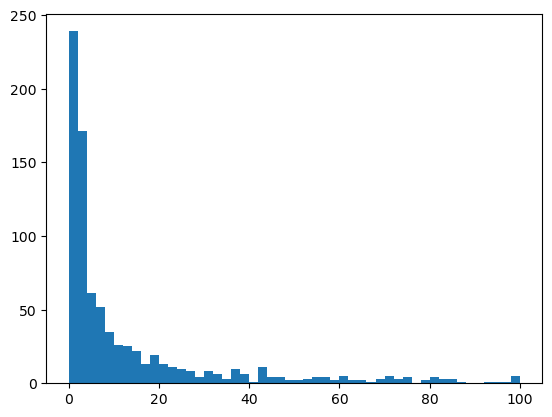

In [3]:
data_grouped_sum_gamerounds = data.groupby('sum_gamerounds')['user_id'].count().reset_index()

plt.hist(data_grouped_sum_gamerounds['user_id'], bins=50, range=(0, 100))
plt.show()

Having a more closer look limiting the range to 20, we can see most of the players didn't even play the game. Also it had a steep drop after playing round 2 or 3. 

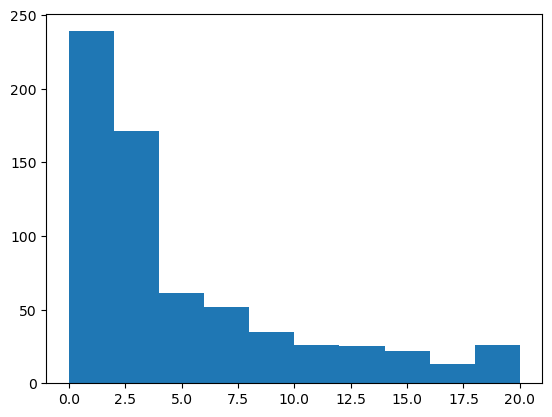

In [4]:
plt.hist(data_grouped_sum_gamerounds['user_id'], range=(0, 20))
plt.show()

From total 90189 players 3994 players didn't even start the game after installing. That is more than 4% of the total players. 

In [5]:
not_played = data_grouped_sum_gamerounds[data_grouped_sum_gamerounds['sum_gamerounds'] == 0].sum()[1]

print(f"Percentage of not played: {round(not_played * 100 / 90189, 2)}%")

Percentage of not played: 4.43%


Looks like the versions distributed evenly to all players.

In [13]:
data.groupby('version')[['user_id']].nunique().reset_index()

,version,user_id
0,gate_30,44700
1,gate_40,45489


Almost half of the players came back and play the game 1 day after installing. 

In [21]:
re_1_mean = data['retention_1'].mean()*100
re_7_mean = data['retention_7'].mean()*100

print(f"Players come back after day 1: {round(re_1_mean, 2)}%")
print(f"Players come back after day 7: {round(re_7_mean, 2)}%")

Players come back after day 1: 44.52%
Players come back after day 7: 18.61%


We group by the `version` and get the retention rate for each version. We can see for the `gate_30` the retention rate of both `retention_1` and `retention_7` increased slightly, whereas `gate_40` decreased the retention rate. 

- Retention rate after day 1 from total is 44.52% when the gate was moved from 30 to 40 it only made the detention rate to decrease (44.22%)
- Also the retention rate after day 7 slightly decreased from total retention rate 18.61% to 18.2% when the gate was moved to 40

This could give us an idea that changing the gate from 30 to 40 doesn't have any significant difference so we might have to stick the gate on 30. 

Let's move on to check if this is true. 

In [24]:
data_retention_ab = data.groupby('version').agg({'user_id': 'count', 
                                                 'retention_1': 'mean', 
                                                 'retention_7': 'mean', 
                                                 'sum_gamerounds': 'sum'})
data_retention_ab

,user_id,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


## Hypothesis

Let's set the null and alternative hypothesis.

H0 - Null Hypothesis: There is no significant difference in the number of rounds played between two different versions.

H1 - Alternative Hypothesis: There is a significant difference in the number of rounds played between two different versions.

After we conduct an A/B test we will have the p-value result. According to the p-value we will decide which hypothesis we will follow. 

- If p-value < 0.05: We reject the null hypothesis and conclude that there is a significant difference in the number of rounds played between two versions. 
- If p-value > 0.05: We cannot reject the null hypothesis. Hence, there is no significant difference in the number of rounds played between two version. 

### 1. Normality Assumption Check

Before moving into the actual A/B test, let's see if the data is normally distributed. The assumption of normality in A/B test is crucial since the parametric tests works on the assumption that the data is normally distributed. Also having the data normally distributed the reliablility of the result grows higher. 

For the normality check, we will conduct a **Shapiro-Wilk Test**. With this test we will have two hypothesis; 
- Null Hypothesis (H0): the assumption is normally distributed 
- Alternative Hypothesis(H1): the assumption is not normally distributed. 

The p-value of the Shapiro-Wilk test will determine if we can reject or not reject the null hypothesis. If the p-value is less than or equal to 0.05 (assuming a 95% confidence level), then the data is assumed to not fit in the normal distribution. 

We can see that for both `gate_30` and `gate_40` has the p-value less than 0.05 meaning our data doesn't have a normal distribution. We will reject the null hypothesis. 

In [29]:
stat, pval = shapiro(data.loc[data['version'] == 'gate_30', 'sum_gamerounds'])
print(f"Test stat: {stat}\nP-Value: {pval}")

Test stat: 0.08805108070373535
P-Value: 0.0


In [36]:
stat, pval = shapiro(data.loc[data['version'] == 'gate_40', 'sum_gamerounds'])
print(f"Test stat: {stat}\nP-Value: {pval}")

Test stat: 0.48256635665893555
P-Value: 0.0


/Users/eunaecho/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### 2. Homogeneity of Variance Assumption Check

In A/B test, homogeneity of variance is important when performing parametric tests like t-test. If the variances between groups are significantly different, it can affect the reliablility of the test result. 

We will use **Levene's test** to check the assumption of homogeneity. We can set the hypothesis for this test as below. 

- Null Hypothesis (H0): The variance are homogeneous. 
- Alternative Hypothesis (H1): The variance are not homogeneous.

We also use the p-value to determine the homogeneity of variance.

- If the p-value is less than 0.05, there's a significant difference between the variances. We can reject the null hypothesis. 
- If the p-value is greater than 0.05, the variances are not significantly different from each other. In other words, the homogeneity assumption of the variance is met. Null hypothesis cannot be rejected. 

We can see the p-value (0.46) being above 0.05 so we can say there is no significant difference between the two variances. Null hypothesis cannot be rejected. 

In [39]:
stat, pval = levene(data.loc[data['version'] == 'gate_30', 'sum_gamerounds'],
                   data.loc[data['version'] == 'gate_40', 'sum_gamerounds'])
print(f"Test stat: {stat}\nP-Value: {pval}")

Test stat: 0.5292002638313259
P-Value: 0.46694516772623273


Since the normal distribution assumption was rejected and homogeneity of variance not rejected we can conduct a **Mann-Whitney U test**. 

The Mann-Whitney U test is a non-parametric statistical test used to evaluate the difference in <u>*medians*</u> between two independent groups. Non-parametric tests are used when data does not follow a normal distribution or when homogeneity of variances is violated. The Mann-Whitney U test uses medians to access central tendency differences between groups and operates on the ranked data. 

For your information, if the above assumptions were met, then **independent two-sample t-test** could be a good option. The independent two-sample t-test is a parametric statistical test used to access the statistical difference between the <u>*means*</u> of two different groups. 

Since the p-value from the Mann-Whitney U test is greater than 0.05 our null hypothesis (*There is no significant difference in the number of rounds played between two different versions.*) cannot be rejected. 

In [42]:
stat, pval = mannwhitneyu(data.loc[data['version'] == 'gate_30', 'sum_gamerounds'],
                   data.loc[data['version'] == 'gate_40', 'sum_gamerounds'])
print(f"Test stat: {stat}\nP-Value: {pval}")

Test stat: 1024331250.5
P-Value: 0.05020880772044255


## Conclusion

In this notebook, we tried to understand the business problem the mobile game Cookie Cats are facing. Currently the game has a gate set on level 30 but wanted to know if changing the gate to level 40 could bring more effective business outcome. 

We first familiarized outselves on the data and figured out that having the gate on level 30 is slightly better than placing it on gate 40. However we needed to have more investigation by going through an A/B test to see having the gate set to current level 30 is better. 

Before conducting the actual test we checked if the data is in a normal distribution and homogeneity in variance assumption is made. It turned out that the data is not normally distributed, but the homogeneity in variance was made. According to this result, we decided to choose Mann-Whitney U test that is a non-parametric test suitable for data that is not normally distributed. 

The test result showed with a p-value greater than 0.05 meaning there is no significant difference in the number of rounds played between two different versions. This supports our hypothesis that leaving the gate on level 30 is better than moving it to level 40. 

In conclusion, we suggest the client to leave the gate on level 30. 

Extra advice that could be given to the client is to concentrate on the players that don't even play the game after installing since the percentage is quite a lot. Almost 5% of players didn't ever start the game. If there could be any sort of incentive that could attract the first time players could make more differences with the outcome the client expects. 